# Fit a Function with Keras TensorFlow

The [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that a neural network with at least one hidden layer can represent an arbitrarily complex function. This is similar to a Fourier series or Taylor series approximation. 

In this notebook we'll explore how to use Keras/TensorFlow to model an arbitrary function.

## Define the libraries we want to use:  TensorFlow (includes Keras), NumPy, and Matplotlib

[Keras](http://keras.io) is an API for defining neural network topologies.  It is the preferred API for TensorFlow but also works for some other deep learning frameworks. 

In [17]:
import tensorflow as tf   # Import TensorFlow
import numpy as np        # Import NumPy

print("Is TensorFlow enabled with Intel optimizations? {}".format(tf.pywrap_tensorflow.IsMklEnabled()))

Is TensorFlow enabled with Intel optimizations? True


In [2]:
import matplotlib.pyplot as plt   # Matplotlib: this allows us to plot things
%matplotlib inline

## Define the function we want to approximate with the TensorFlow model

In [3]:
def functionA(x):
    """
    Let's just define any type of function here for TensorFlow to approximate.
    Feel free to change this to whatever function you'd like to approximate.
    """
    
    return x**5 - x**3 + np.random.rand(len(x))*.01


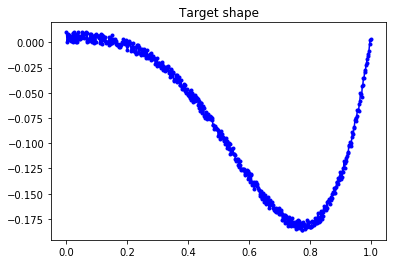

In [4]:
# Take some random points between 0 and 1 to evaluate the function
# We'll have a training set to fit the model and a test set to evaluate how well the model will generalize

# Create training set
N_train = 10000   # number of data points in training set
x_train = np.random.rand(N_train)  # Random points from 0 to 1
y_train = functionA(x_train)

# Create the test set
N_test = 500   # Number of data points in testing set
x_test = np.linspace(0, 1, N_test)  # In order N_test points from 0 to 1
y_test = functionA(x_test)

plt.plot(x_test, y_test, color="b", marker=".")
plt.title("Target shape");

# Define a neural network with Keras

This will be a Multilayered Perceptron (MLP) with a single input (the x value).  We want the output of the model to be the y value associated with that x (so it should approximate the function).

I highly recommend using the Keras [Functional API](https://keras.io/getting-started/functional-api-guide/) which is much more extensible than the Keras Sequential API.  The Functional API allows you create very complex topologies with multiple inputs/outputs, multiple paths, and skip connections.

In [5]:
inputs_to_model = tf.keras.layers.Input([1], name="myInput")   # There's just a single value input

# 1st hidden layer has 200 neurons and goes to a ReLU activation
layer1 = tf.keras.layers.Dense(units=200, name="myLayer1")(inputs_to_model)
activate1 = tf.keras.layers.Activation("relu")(layer1)

# 2nd hidden layer has 100 neurons and goes to a ReLU activation
layer2 = tf.keras.layers.Dense(units=100, name="yourLayer2")(activate1)
activate2 = tf.keras.layers.Activation("relu")(layer2)

# Output layer has 1 neuron (the predicted y value) and no activation
outputs_to_model = tf.keras.layers.Dense(units=1, name="myPrediction")(activate2)

## Tell Keras what inputs and outputs the model should expect

In [6]:
model = tf.keras.models.Model(inputs=[inputs_to_model], outputs=[outputs_to_model])

model.summary()  # Ask Keras to print the model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
myInput (InputLayer)         (None, 1)                 0         
_________________________________________________________________
myLayer1 (Dense)             (None, 200)               400       
_________________________________________________________________
activation (Activation)      (None, 200)               0         
_________________________________________________________________
yourLayer2 (Dense)           (None, 100)               20100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
myPrediction (Dense)         (None, 1)                 101       
Total params: 20,601
Trainable params: 20,601
Non-trainable params: 0
_________________________________________________________________


## Neural network math - aka never forget the bias unit

The equation is always the equation of a line (or hyperplane) 

$ y = mx + b $

or

$ output = \text{(units in layer + bias)} \times input $

_n.b._ The bias term can be brought inside the multiplication because we actually consider the input to the bias term as a constant 1.  This allows the network to learn the bias (which just becomes another weight to learn).

The __Dense__ layer is just a wrapper in Keras to define the TensorFlow operations for $ y = mx + b $.

Here's the math for the network we've created:

*myLayer1* has 200 units and takes *myInput* as the input layer.  

*myInput* has 1 unit, but we always have to add the bias term so it is actually 2 units.  That means there are 400 trainable parameters for *myLayer1*:

$ (1 + 1) \times 200 = 400 \text{ parameters for } \bf{myLayer1}$

*yourLayer2* has 100 units. The input is *activation* which has 200 units, but we always have the additional bias unit. So it is actually 201 units as input to *yourlayer2*.  This means there are 20,100 trainable parameters in *yourLayer2*.

$ (200 + 1) \times 100 =  20,100 \text{ parameters for } \bf{yourLayer2}$

*myPrediction* only has 1 unit. The input is *activation_2* which has 100 units, but we always have the additional bias unit. So it is actually 101 units as input to *myPrediction* for a total of 101 trainable parameters:

$ (100 + 1) \times 1 =  101 \text{ parameters for } \bf{myPrediction}$

![model_diagram](./keras_function_model.png)

## Compile the Keras model using MSE as the loss function and SGD as the optimizer

In [7]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss="mean_squared_error", optimizer=sgd)

## Train the compiled model on the training dataset for 10 epochs

Typically the more epochs the better results up until a certain point. After that you'll either not get any more benefit from training or you will overtfit to your training data. If you overfit, then the model will not do a good job on data it has never seen before (aka it won't generalize well).

In [8]:
number_of_epochs = 1
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test));

Train on 10000 samples, validate on 500 samples
Epoch 1/1
10000/10000 [==============================] - 1s 127us/step - loss: 0.0019 - val_loss: 0.0013


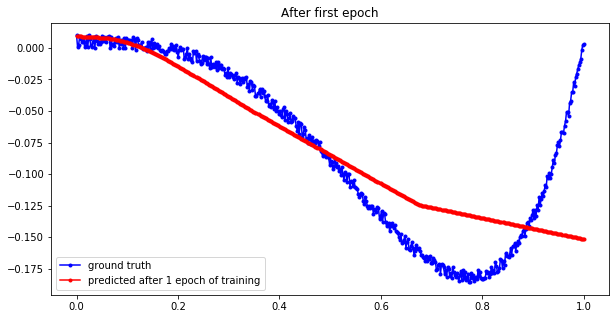

In [9]:
prediction_first1 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.title("After first epoch");
plt.legend(["ground truth", "predicted after 1 epoch of training"]);

In [10]:
number_of_epochs = 10
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test));

Train on 10000 samples, validate on 500 samples
Epoch 1/10
10000/10000 [==============================] - 0s 44us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 2/10
10000/10000 [==============================] - 1s 78us/step - loss: 9.9808e-04 - val_loss: 9.4132e-04
Epoch 3/10
10000/10000 [==============================] - 1s 79us/step - loss: 8.4781e-04 - val_loss: 7.9264e-04
Epoch 4/10
10000/10000 [==============================] - 1s 78us/step - loss: 7.1326e-04 - val_loss: 6.8921e-04
Epoch 5/10
10000/10000 [==============================] - 1s 79us/step - loss: 6.0298e-04 - val_loss: 5.6492e-04
Epoch 6/10
10000/10000 [==============================] - 1s 79us/step - loss: 5.0492e-04 - val_loss: 4.7881e-04
Epoch 7/10
10000/10000 [==============================] - 1s 78us/step - loss: 4.2579e-04 - val_loss: 4.0495e-04
Epoch 8/10
10000/10000 [==============================] - 1s 80us/step - loss: 3.5967e-04 - val_loss: 3.4053e-04
Epoch 9/10
10000/10000 [==============================] 

## Evaluate the trained model on the test dataset

In [11]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=10)

print(loss_and_metrics)

500/500 [==============================] - 0s 95us/step
0.00025358718437928473


In [12]:
## Use the model to predict the test dataset

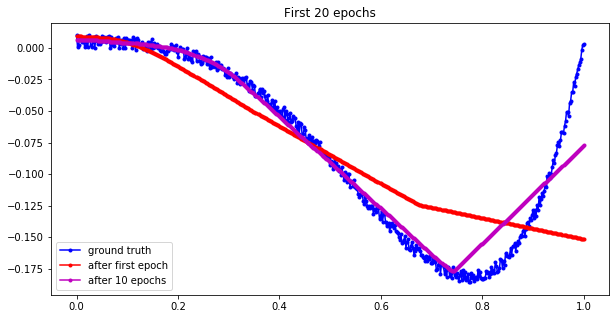

In [13]:
prediction_first10 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.title("First 20 epochs");
plt.legend(["ground truth", "after first epoch", "after 10 epochs"]);

## Let's do another 10 epochs and see how much better we can do

Train on 10000 samples, validate on 500 samples
Epoch 1/10
10000/10000 [==============================] - 0s 38us/step - loss: 2.2868e-04 - val_loss: 2.2839e-04
Epoch 2/10
10000/10000 [==============================] - 0s 35us/step - loss: 1.9932e-04 - val_loss: 1.9205e-04
Epoch 3/10
10000/10000 [==============================] - 0s 34us/step - loss: 1.7525e-04 - val_loss: 1.6813e-04
Epoch 4/10
10000/10000 [==============================] - 0s 35us/step - loss: 1.5450e-04 - val_loss: 1.4851e-04
Epoch 5/10
10000/10000 [==============================] - 1s 78us/step - loss: 1.3717e-04 - val_loss: 1.3289e-04
Epoch 6/10
10000/10000 [==============================] - 1s 78us/step - loss: 1.2348e-04 - val_loss: 1.1902e-04
Epoch 7/10
10000/10000 [==============================] - 1s 77us/step - loss: 1.1055e-04 - val_loss: 1.0965e-04
Epoch 8/10
10000/10000 [==============================] - 1s 75us/step - loss: 1.0056e-04 - val_loss: 9.8502e-05
Epoch 9/10
10000/10000 [========================

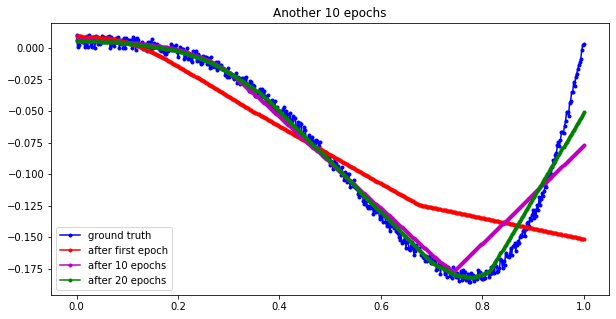

In [14]:
number_of_epochs = 10
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=1, validation_data=(x_test, y_test))

prediction_second10 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.plot(x_test, prediction_second10, color="g", marker=".");
plt.title("Another 10 epochs");
plt.legend(["ground truth", "after first epoch", "after 10 epochs", "after 20 epochs"]);

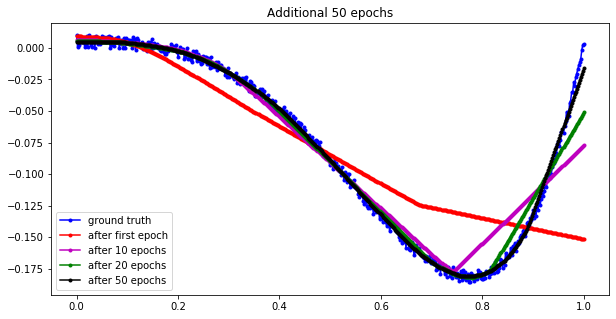

In [15]:
number_of_epochs = 50
model.fit(x_train, y_train, epochs=number_of_epochs, batch_size=32, verbose=0, validation_data=(x_test, y_test))

prediction_additional50 = model.predict(x_test, batch_size=1)

plt.figure(figsize=(10,5))
plt.plot(x_test, y_test, color="b", marker=".");
plt.plot(x_test, prediction_first1, color="r", marker=".");
plt.plot(x_test, prediction_first10, color="m", marker=".");
plt.plot(x_test, prediction_second10, color="g", marker=".");
plt.plot(x_test, prediction_additional50, color="k", marker=".");
plt.title("Additional 50 epochs")
plt.legend(["ground truth", "after first epoch", "after 10 epochs", "after 20 epochs", "after 50 epochs"]);

## Let's save this model to a file so that we can use it again

In [16]:
model.save("my_great_keras_model.hdf5")

## You can use a model viewer like Netron to look at the model diagram

https://lutzroeder.github.io/netron/
    